<h3>Train Autoencoder on Strucutred Data</h3>
<p>Train the autoencoder on the structured data and use the reconstruction error for each sample as an anomaly score.</p>
<p>Samples with higher reconstruction errors may represent more severe health conditions</p>

Trial 20 Complete [00h 00m 15s]
val_loss: 0.0970614105463028

Best val_loss So Far: 0.0012060635490342975
Total elapsed time: 00h 29m 14s

The optimal number of layers is 2 encoder and decoder layers.
The optimal number of units in each layer are:
Encoder units: [512, 512]
Decoder units: [384, 384]
The optimal activation function is relu.
The optimal encoding dimension is 224.
The optimal learning rate is 0.00013770364765086166.

Epoch 1/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3027 - val_loss: 0.0202
Epoch 2/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0200 - val_loss: 0.0126
Epoch 3/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0139 - val_loss: 0.0090
Epoch 4/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0116 - val_loss: 0.0067
Epoch 5/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0073 - val_loss: 0.0086
Epoch 6/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0092 - val_loss: 0.0061
Epoch 7/50
1461/1461 ━━━━━━━━━━━━━━━━━

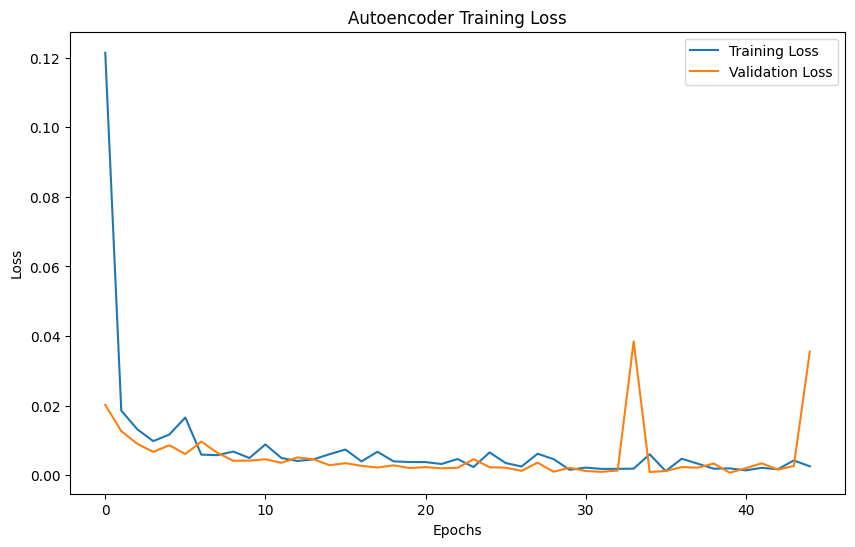

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras_tuner import HyperModel, BayesianOptimization

# Load preprocessed structured data
structured_data = pd.read_csv('structured_data_preprocessed.csv')

# Separate features
X_structured = structured_data.values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_structured)

# Train-test split
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Define the Hypermodel
def build_autoencoder(hp):
    input_dim = X_train.shape[1]
    input_layer = layers.Input(shape=(input_dim,))

    # Encoding Layers
    x = input_layer
    num_layers = hp.Int('num_layers', 1, 3)
    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=64, max_value=512, step=64)
        x = layers.Dense(units, activation=hp.Choice('activation', ['relu', 'tanh']))(x)
    
    # Bottleneck Layer
    encoding_dim = hp.Int('encoding_dim', min_value=32, max_value=256, step=32)
    x = layers.Dense(encoding_dim, activation=hp.Choice('activation', ['relu', 'tanh']))(x)
    
    # Decoding Layers
    for i in range(num_layers):
        units = hp.Int(f'units_dec_{i}', min_value=64, max_value=512, step=64)
        x = layers.Dense(units, activation=hp.Choice('activation', ['relu', 'tanh']))(x)
    
    # Output Layer
    decoded = layers.Dense(input_dim, activation='linear')(x)
    
    # Autoencoder Model
    autoencoder = keras.Model(inputs=input_layer, outputs=decoded)
    
    # Compile the model
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse'
    )
    
    return autoencoder

# Set up the tuner
tuner = BayesianOptimization(
    build_autoencoder,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='autoencoder_tuning',
    project_name='vitai_autoencoder'
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Run the hyperparameter search
tuner.search(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal hyperparameters
print(f"""
The optimal number of layers is {best_hps.get('num_layers')} encoder and decoder layers.
The optimal number of units in each layer are:
Encoder units: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
Decoder units: {[best_hps.get(f'units_dec_{i}') for i in range(best_hps.get('num_layers'))]}
The optimal activation function is {best_hps.get('activation')}.
The optimal encoding dimension is {best_hps.get('encoding_dim')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping]
)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
# Save the model
autoencoder.save('autoencoder.h5')

<h3>Compute Reconstruction Error</h3>
<p>After trainig the autoencoder, we will compute the reconstruction error for each patient</p>
<p>The reconstruction error serves as an <strong>anomaly score</strong>. We can interpret higher reconstruction errors as higher severity levels.</p>

3652/3652 ━━━━━━━━━━━━━━━━━━━━ 2s 659us/step


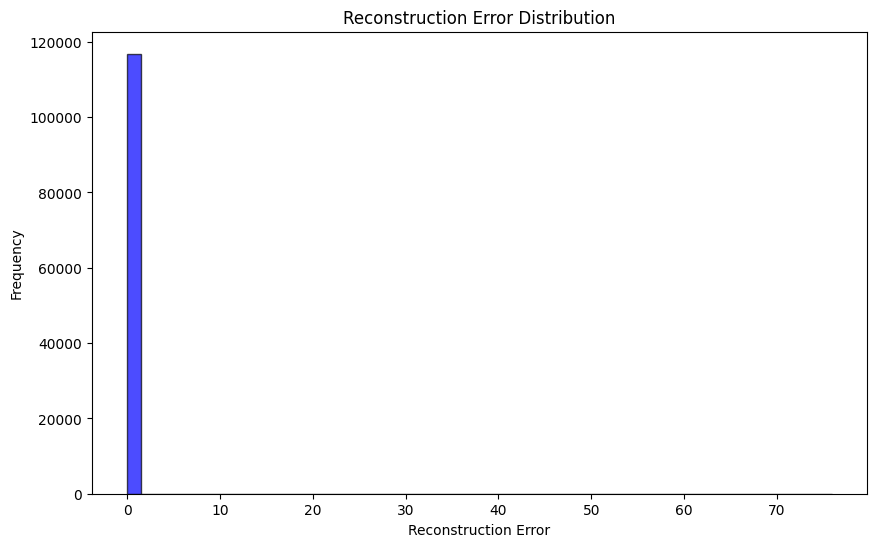

In [11]:
# Compute reconstruction error for the entire dataset   
reconstructed = autoencoder.predict(X_scaled)
reconstructed_error = np.mean(np.square(X_scaled - reconstructed), axis=1)

#Add reconstruction error to the structured data
structured_data['Reconstruction Error'] = reconstructed_error

#Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstructed_error, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()


<h3>Latent Representaions</h3>
<p>Extract the latent features from the encoder part of the autoencoder for further analysis</p>

In [12]:
#Create encoder model
encoder = models.Model(inputs = autoencoder.input, outputs = encoded)

#Obtain latent representation
latent_features = encoder.predict(X_scaled)

#Create a DataFrame for latent features
latent_features_df = pd.DataFrame(data=latent_features, columns=[f'latent_{i}' for i in range(encoding_dim)])

#Add reconsturction error to the latent features DF
latent_features_df['reconstruction_error'] = reconstructed_error

#Save the latent features
latent_features_df.to_csv('latent_features.csv', index=False)

3652/3652 ━━━━━━━━━━━━━━━━━━━━ 2s 439us/step


<h3>Apply Clustering Algorithm</h3>
<p>We apply a clustering algorithm on the combined latent features to idnentify groups of patients that may correspond to different levels of health severity.</p>
<p>We use K-Means clustering to group patients based on their latent features</p>
<p>The silhouette score helps determine the optimal number of clusters</p>

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the silhouette score
range_n_clusters = list(range(2, 10))
best_n_clusters = 0
best_score = -1

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_features_df)
    silhouette_avg = silhouette_score(latent_features_df, cluster_labels)
    print(f'For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}')
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

print(f'Best number of clusters: {best_n_clusters}')

# Apply KMeans with the best number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_features_df)

# Add cluster labels to the DataFrame
latent_features_df['cluster'] = cluster_labels

For n_clusters = 2, the average silhouette_score is : 0.3389434258157313
For n_clusters = 3, the average silhouette_score is : 0.16259648041595604
For n_clusters = 4, the average silhouette_score is : 0.15275168438103195


KeyboardInterrupt: 

<h3>Assign Health Severity Index</h3>
<p>We assing a severit index based on the cluster assignments.</p>
<p>Clusters represent different groups of patients with varying health conditions</p>
<p>By assinging severity scores based on cluster labels, we derive a health severiy index without human bias</p>

In [6]:
# Map clusters to severity scores
# Assuming higher cluster labels correspond to higher severity
# If not, you may need to analyze clusters to order them appropriately

# Map cluster labels to severity scores (e.g., 0 to N-1)
cluster_severity = {cluster: index for index, cluster in enumerate(sorted(latent_features_df['cluster'].unique()))}
latent_features_df['severity_index'] = latent_features_df['cluster'].map(cluster_severity)

# Optionally, scale severity index to 0-10 range
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 10))
latent_features_df['severity_index_scaled'] = scaler.fit_transform(latent_features_df[['severity_index']])

<h3>Analyse and Validate Clusters</h3>
<p>It's important to analyse the clusters to ensure they make clinical sense.</p>
<p>By exmamining the characteristics of each cluster, you can interpret the severity levles.</p>
<p>*look for patterns in the data that correlate with the clusters*</p>

In [ ]:
# # Combine original data with cluster labels
# analysis_df = structured_data.copy()
# analysis_df['cluster'] = latent_features_df['cluster']
# analysis_df['severity_index'] = latent_features_df['severity_index_scaled']
# analysis_df['reconstruction_error'] = structured_data['Reconstruction Error']  # Add this line

# # Group by cluster and compute summary statistics
# cluster_summary = analysis_df.groupby('cluster').mean()
# print(cluster_summary)

# # Visualize reconstruction error by cluster
# import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.boxplot(x='cluster', y='reconstruction_error', data=analysis_df)
# plt.title('Reconstruction Error by Cluster')
# plt.xlabel('Cluster')
# plt.ylabel('Reconstruction Error')
# plt.show()

# # Visualize key features by cluster
# key_features = structured_data.columns.tolist()  # List of feature names

# for feature in key_features:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='cluster', y=feature, data=analysis_df)
#     plt.title(f'Distribution of {feature} by Cluster')
#     plt.xlabel('Cluster')
#     plt.ylabel(feature)
#     plt.show()


<p>Need restart kernel? Dw I've got you</p>

In [8]:
# import os
# import IPython

# # Restart the kernel
# os._exit(00)